Step Function 

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_style('whitegrid')

Define Regression Function

In [2]:
def reg(x):
    return 5*np.sin(x)+ 23*(np.cos(x))**2

Generate data

In [3]:
np.random.seed(1234)
X = np.random.uniform(5, 15, 100)
Y = reg(X) + np.random.normal(0, 5, 100)

sample = pd.DataFrame({'X': X, 'Y': Y})
sample.head()

,X,Y
0,6.915195,21.763548
1,11.221088,1.201202
2,9.377277,24.539737
3,12.853586,29.530616
4,12.799758,23.325363


Split into train and test sets

In [4]:
Train = sample.iloc[:80]
Test = sample.iloc[80:]

Plotting the data

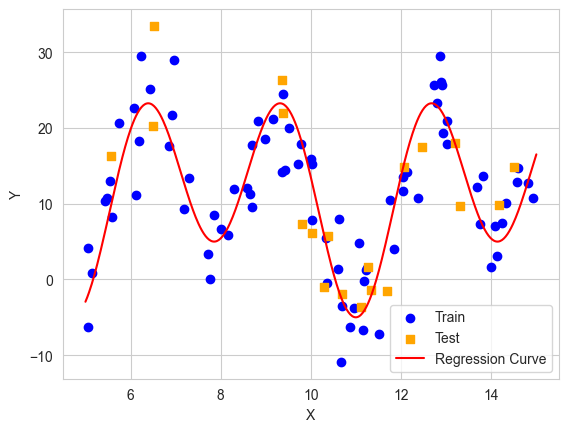

In [5]:
plt.scatter(Train['X'], Train['Y'], marker='o', label='Train',color='blue')
plt.scatter(Test['X'], Test['Y'], marker='s',label='Test',color='orange')

# Regresion curve
x_curve = np.linspace(5, 15, 500)
y_curve = reg(x_curve)
plt.plot(x_curve, y_curve, color='red', label='Regression Curve')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Define step function as class

In [6]:
class StepFunction:
    def __init__(self, x, y):
        if (len(x)-1) != len(y):
            raise ValueError('Length of X should be one more than Y')
        self.X = x
        self.Y = y

    def predict(self, z):
        # predict the step function at input z (either scalar or array)
        z= np.asarray(z)  # convert to numpy array to ensure if not alraedy
        result = np.zeros_like(z, dtype=float)

        for i in range(len(self.Y)):
            # Assign the value of Y[i] to all z values in the range [X[i], X[i+1])
            result[(z >= self.X[i]) & (z < self.X[i+1])] = self.Y[i]
        return result

Define Bin Smoothing function 

In [7]:
def BinSmoothing(k, Train, Test, reg_func, plot=True):
    x_train = Train['X'].values
    y_train = Train['Y'].values

    # Define the bins
    bin_width = (max(x_train) - min(x_train)) / k
    bins = np.linspace(min(x_train), max(x_train), k+1)
    bin_means = []  # or we can use np.zeros(k) to preallocate

    for i in range(k):
        # Get the indices of the training data that fall into the current bin
        indices = np.where((x_train >= bins[i]) & (x_train < bins[i+1]))[0]
        if len(indices) > 0:
            # Calculate the mean of Y values in this bin
            bin_mean = np.mean(y_train[indices])
        else:
            # If no data points in this bin, use NaN or some other value
            bin_mean = np.nan
        bin_means.append(bin_mean)

    # apply the step function
    step_func = StepFunction(bins, bin_means)

    if plot:
        # scatter plot of the training data
        plt.figure(figsize=(10, 6))
        plt.scatter(x_train, y_train, marker='o', label='Train', color='blue')
        plt.scatter(Test['X'], Test['Y'], marker='s', label='Test', color='orange')
        # plot the true regression curve
        x_curve = np.linspace(min(x_train), max(x_train), 500)
        plt.plot(x_curve, reg_func(x_curve), color='red', label='Regression Curve')

        # plot the step function
        plt.plot(x_curve, step_func.predict(x_curve), color='green', label='Step Function')
        for bin in bins:
            plt.axvline(x=bin, color='gray', linestyle='--', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f'Bin width = {bin_width}')
        plt.show()

    # calculate the mean squared error
    y_pred = step_func.predict(x_train)
    mse_train = np.mean((y_train - y_pred)**2)
    y_pred = step_func.predict(Test['X'])
    mse_test = np.mean((Test['Y'] - y_pred)**2)

    return [mse_train, mse_test]

Testing the functions

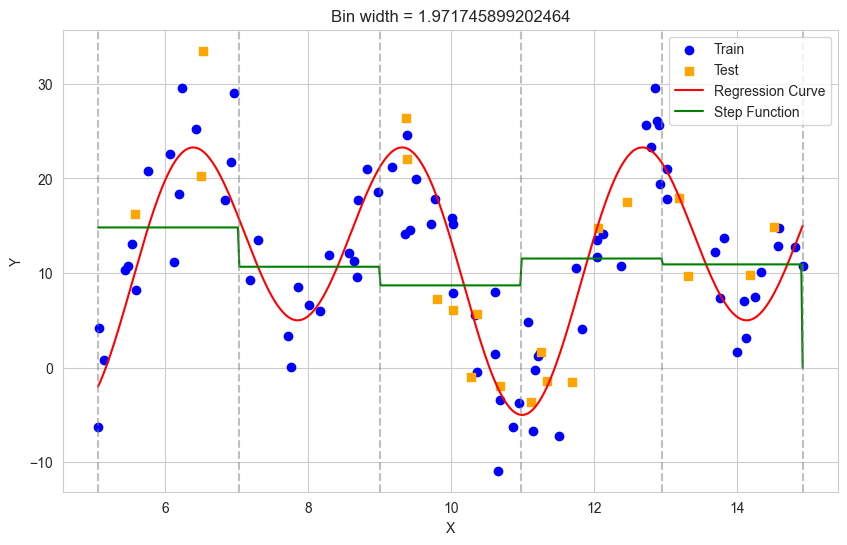

[np.float64(82.76935194691656), np.float64(93.97514318044938)]

In [8]:
BinSmoothing(5, Train, Test, reg)

   Bin width (k)  MSE (Train)  MSE (Test)
0              5    82.769352   93.975143
1             10    36.617699   30.414443
2             15    22.371767   50.590200
3             20    22.102942   32.788956
4             25    18.760596   23.894338
5             30    12.257019   40.246080
6             35    13.893887   31.325823
7             40    13.446339   24.012293
8             45    13.056495   30.872645
9             50    12.081511   26.513044


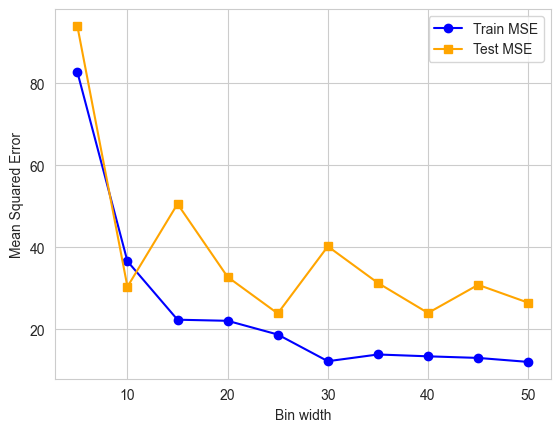

In [9]:
k = np.arange(5,51,5)
mse_train = []
mse_test = []

for i in k:
    mse_train_i, mse_test_i = BinSmoothing(i, Train, Test, reg, False)
    mse_train.append(mse_train_i)
    mse_test.append(mse_test_i)

table = pd.DataFrame({'Bin width (k)': k, 'MSE (Train)': mse_train, 'MSE (Test)': mse_test})  
print(table)

plt.plot(k, mse_train, marker='o', label='Train MSE', color='blue')
plt.plot(k, mse_test, marker='s', label='Test MSE', color='orange')
plt.xlabel('Bin width')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()